In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from gen_results import gen_save_cr_cm # Load test results
import pandas as pd
import seaborn as sns

import json
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# @todo Load perturbation functions

In [3]:
preprocessing_fp = "preprocessing/combined_filtered"
BATCH_SIZE = 32
EPOCHS = 50
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
LABELS = ["female", "male"]

In [4]:
# Load train dataset
train_dataset = image_dataset_from_directory(os.path.join(preprocessing_fp, "train"),
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

# Load validation dataset
validation_dataset = image_dataset_from_directory(os.path.join(preprocessing_fp, "val"),
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 29026 files belonging to 2 classes.
Found 8275 files belonging to 2 classes.


In [5]:
# Use buffered prefetching to load images without having I/O blocking
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
# Helpful since we want to expand our image dataset
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [7]:
# Load MobileNetV3 Large
preprocess_input_mobile = tf.keras.applications.mobilenet_v3.preprocess_input
base_model_mobile = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Load DenseNet 201
preprocess_input_dense = tf.keras.applications.densenet.preprocess_input
base_model_dense = tf.keras.applications.densenet.DenseNet201(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Load ResNet50
preprocess_input_res = tf.keras.applications.resnet50.preprocess_input
base_model_res = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Model Training

In [8]:
def create_model(base_model, preprocess_input):
    # Converts images into a 5x5x1280 block of features
    image_batch, label_batch = next(iter(train_dataset))
    feature_batch = base_model(image_batch)
    
    # Freeze all convolutional base
    base_model.trainable = False
    
    # Add classification head
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    
    # Model building
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
    outputs = keras.layers.Dense(1,activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    # Compile the model
    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [9]:
# Create the three different models
model_mobile = create_model(base_model_mobile, preprocess_input_mobile)
model_dense = create_model(base_model_dense, preprocess_input_dense)
model_res = create_model(base_model_res, preprocess_input_res)

In [10]:
def model_training(model, suffix):
    """
    Trains model, and saves model's best weights and history
    """
    checkpoint = ModelCheckpoint(
        "model_tl_best_weights_{}.h5".format(suffix),
        monitor="loss",
        verbose=0,
        save_best_only=True,
        mode="min",
        save_freq="epoch",
    )

    # Save a checkpoint of the model for later use
    history = model.fit(train_dataset,
                             epochs=EPOCHS,
                             validation_data=validation_dataset,
                            callbacks=[checkpoint])

    # Store model history as a JSON file
    with open(os.path.join("history", "model_tl_history_{}.json".format(suffix)), "w") as f:
        json.dump(history.history, f) # Construct the baseline (unperturbed) model
        
    return history

In [11]:
# Train each of the models
history_mobile = model_training(model_mobile, 'mobile')
history_dense = model_training(model_dense, 'dense')
history_res = model_training(model_res, 'res')

Epoch 1/50
908/908 [==============================] - 24s 24ms/step - loss: 0.5605 - accuracy: 0.7013 - val_loss: 0.4664 - val_accuracy: 0.7720
Epoch 2/50
908/908 [==============================] - 21s 23ms/step - loss: 0.4956 - accuracy: 0.7524 - val_loss: 0.4580 - val_accuracy: 0.7741
Epoch 3/50
908/908 [==============================] - 21s 23ms/step - loss: 0.4917 - accuracy: 0.7539 - val_loss: 0.4408 - val_accuracy: 0.7896
Epoch 4/50
908/908 [==============================] - 21s 23ms/step - loss: 0.4731 - accuracy: 0.7640 - val_loss: 0.4337 - val_accuracy: 0.7919
Epoch 5/50
908/908 [==============================] - 21s 23ms/step - loss: 0.4715 - accuracy: 0.7658 - val_loss: 0.4273 - val_accuracy: 0.7983
Epoch 6/50
908/908 [==============================] - 21s 23ms/step - loss: 0.4627 - accuracy: 0.7756 - val_loss: 0.4395 - val_accuracy: 0.7906
Epoch 7/50
908/908 [==============================] - 20s 22ms/step - loss: 0.4611 - accuracy: 0.7731 - val_loss: 0.4274 - val_accuracy:

# Model Analysis

## Plot Accuracy and Loss graphs over 50 epochs

In [12]:
def plot_acc_loss_graph(history):
    acc = []
    val_acc = []
    loss = []
    val_loss = []

    acc += history['accuracy']
    val_acc += history['val_accuracy']

    loss += history['loss']
    val_loss += history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [13]:
# Load histories
with open('history/model_tl_history_mobile.json') as f:
    history_mobile = json.load(f)
with open('history/model_tl_history_dense.json') as f:
    history_dense = json.load(f)
with open('history/model_tl_history_res.json') as f:
    history_res = json.load(f)

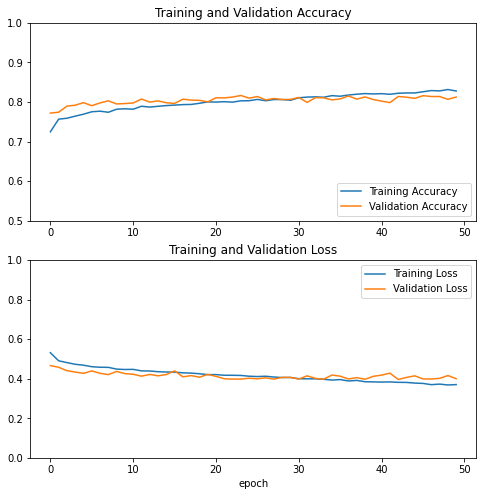

In [14]:
# Accuracy and Loss graphs for MobileNet
plot_acc_loss_graph(history_mobile)

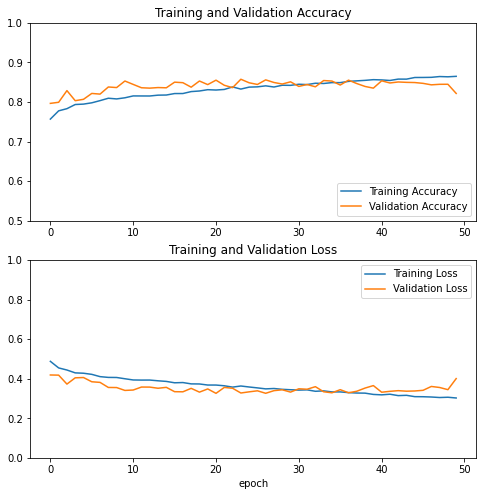

In [17]:
# Accuracy and Loss graphs for DenseNet
plot_acc_loss_graph(history_dense)

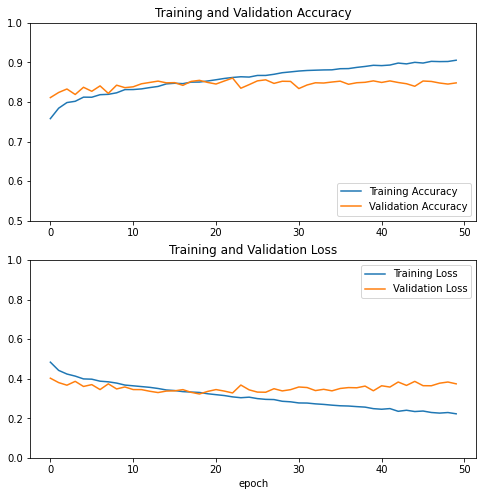

In [18]:
# Accuracy and Loss graphs for ResNet50
plot_acc_loss_graph(history_res)

## Confusion Matrix

In [3]:
# Classification reports and confusion matrices for MobileNet
cr_mobile_all, cm_mobile_all = gen_save_cr_cm('mobile')
cr_mobile_male, cm_mobile_male = gen_save_cr_cm('mobile', 'male')
cr_mobile_female, cm_mobile_female = gen_save_cr_cm('mobile', 'female')

# Classification reports and confusion matrices for DenseNet
cr_dense_all, cm_dense_all = gen_save_cr_cm('dense')
cr_dense_male, cm_dense_male = gen_save_cr_cm('dense', 'male')
cr_dense_female, cm_dense_female = gen_save_cr_cm('dense', 'female')

# Classification reports and confusion matrices for ResNet
cr_res_all, cm_res_all = gen_save_cr_cm('res')
cr_res_male, cm_res_male = gen_save_cr_cm('res', 'male')
cr_res_female, cm_res_female = gen_save_cr_cm('res', 'female')

Testing on male dataset (test_ori)...: 100%|██████████| 1860/1860 [00:48<00:00, 38.12it/s]
/home/monash/.pyenv/versions/3.6.13/envs/fyp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/monash/.pyenv/versions/3.6.13/envs/fyp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/monash/.pyenv/versions/3.6.13/envs/fyp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero

IsADirectoryError: [Errno 21] Is a directory: 'preprocessing/combined_filtered/test_masked/male/.ipynb_checkpoints'

In [16]:
def load_metrics(model_type, gender):
    """
    Loads in results from folder fyp-ma-13/fyp-models/cr_cm_results
    """
    with open("cr_cm_results/cr_cm_{}_{}".format(model_type, gender)) as json_file:
        data = json.load(json_file)
        data = json.loads(data)
    return data

In [19]:
data = load_metrics("mobile", 'male')

In [21]:
data['cm_mobile_male']

[[0, 0], [744, 1116]]

## Display confusion matrices